# Map the acoustic environment

This notebook creates a map of biophony and anthrophony, predicted from a [multilevel regression model](https://github.com/jacobdein/alpine-soundscapes/blob/master/Regression%20model.ipynb).

The model takes land cover areas (within a specified radius) as input, which this notebook computes for a grid of points over the study area. The output is then overlayed on web background tiles over the study area.

#### Import statements

In [1]:
# datawaves database
from landscape.models import LandCover
from database.models import Site
from geo.models import Boundary
from django.contrib.gis.geos import Point
from django.contrib.gis.db.models.functions import Intersection, Envelope
from django.contrib.gis.db.models import Collect

from os import path
import numpy
import pandas
import pyprind
import pyproj
import folium
from folium.plugins import ImageOverlay
from PIL import Image
from matplotlib import pyplot
from matplotlib import cm
%matplotlib inline

# hd5 to save results between sessions
import h5py

#### Variable declarations

radius — the radius in meters for which to compute land cover areas around each grid location <br />
spacing — the spacing in meters between each grid location <br />
p1, p2 — projections defining the local coordinate system (p1) and the web mapping coordinate system (p2)

In [2]:
radius = 200

In [3]:
spacing = 200

In [4]:
p1 = pyproj.Proj(init='EPSG:31254')  # MGI / Austria GK West
p2 = pyproj.Proj(init='EPSG:4326')   # WGS 84

#### Function declarations

In [5]:
# efficently queries the land cover data 
# to determine the percentage of the specified land cover 
# within a specified radius around a point location
def get_forest_net_area(point, radius=100):
    buffer = point.buffer(radius)
    result = LandCover.objects.filter(shape__intersects=buffer, cover_type__in=[1, 2, 9])\
                          .annotate(intersection=Intersection('shape', buffer))
    forest = result.filter(cover_type__exact=9)
    forest = forest.aggregate(total=Collect('intersection'))
    result = result.aggregate(total=Collect('intersection'))
    try:
        forest_area = forest['total'].area
    except AttributeError:
        forest_area = 0
    try:
        result_area = result['total'].area
    except AttributeError:
        result_area = 0
    net_area = (2 * forest_area) - result_area
    return (net_area / buffer.area) * 100

In [6]:
# utility function to save results between sessions
def export_to_hdf5(filepath, name, data):
    h5f = h5py.File(filepath, 'w')
    h5f.create_dataset(name, data=data)
    h5f.close()

## Create grid of points

load study area boundary from the database

In [7]:
boundary = Boundary.objects.get(name = "study area").geometry.envelope

create a grid of point coordinates (in a numpy array) based on the boundary and desired node spacing

In [8]:
coords = numpy.array(boundary.coords[0])
bbox = dict()
bbox['left'] = coords[:, 0].min()
bbox['bottom'] = coords[:, 1].min()
bbox['right'] = coords[:, 0].max()
bbox['top'] = coords[:, 1].max()

rows = int(numpy.ceil((bbox['top'] - bbox['bottom']) / spacing))
columns = int(numpy.ceil((bbox['right'] - bbox['left']) / spacing))

grid = numpy.empty(shape=(rows, columns), dtype=numpy.ndarray)
x_start = bbox['left']
y_start = bbox['bottom']
for row in range(rows):
    for column in range(columns):
        grid[row, column] = [x_start + (spacing * column), y_start + (spacing * row)]

## Compute land cover area for all points in the grid

In [9]:
values = pandas.DataFrame({'id':numpy.arange(rows*columns), 'forest_net_200m':numpy.zeros(rows*columns)}).set_index('id')

In [17]:
n_calculations = rows * columns
progress = pyprind.ProgBar(n_calculations, bar_char='█', title='progress', monitor=True, stream=1, width=70)

for i, coords in enumerate(grid.ravel()):
    progress.update(item_id=i)
    point = Point(coords)
    value = get_forest_net_area(point=point, radius=radius)
    values['forest_net_200m'].loc[i] = value

progress
0%                                                                  100%
[██████████████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: 2725
Total time elapsed: 03:06:46


## View result

In [11]:
data = values['forest_net_200m'].as_matrix().reshape((rows, columns))
data = numpy.flipud(data)

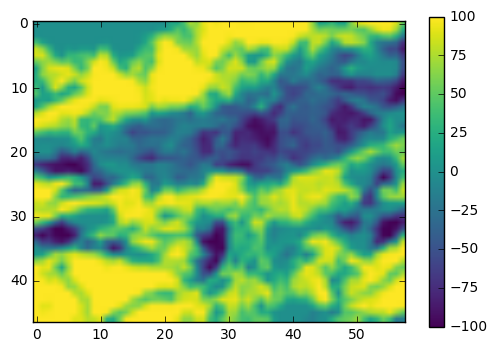

In [12]:
plt1 = pyplot.imshow(data, cmap='viridis')
clb1 = pyplot.colorbar()

## Predict biophony

In [13]:
# import values
#values = pandas.read_csv("")

In [15]:
# reshape into grid
data = values['forest_net_200m'].as_matrix().reshape((rows, columns))
# mean center values (mean computed in the regression model notebook)
u = data - 28.311827066135923
# define model parameters (computed in the regresssion model notebook)
g_00_b = 0.037                                # level 2
g_01_b = 0.039
g_10_b = 0.504
g_11_b = 0.006
a_b = g_00_b + (g_01_b * u)  
b_b = g_10_b + (g_11_b * u)
x = [t for t in numpy.linspace(-3, 3, 21)]    # level 1
y_b = numpy.empty(shape=(len(x), u.shape[0], u.shape[1]), dtype=numpy.float64)
for i, xi in enumerate(x):
    y_b[i] = a_b + (b_b * xi)
# export_to_hdf5(filepath="", name="predicted biophony", data=y)

## Map predicted biophony

transform predicted biophony to range from 0 to 1

In [16]:
y_b = y_b - y_b.min()
y_b = y_b / y_b.max()

define folium map

In [20]:
# center the map on the site named 'Hofgarten' and use the "Stamen Toner" background tiles
map_center = Site.objects.get(name='Hofgarten').geometry.coords
# transfrom the points from MGI / Austria GK West to WGS 84
lon, lat = pyproj.transform(p1, p2, map_center[0], map_center[1])
# intialize the map and use the "Stamen Toner" background tiles
map_b = folium.Map(location=[lat, lon],
                   zoom_start=15, tiles="Stamen Toner", 
                   detect_retina=True)

create the biophony overlay (for x[0]) and add it to the map

In [21]:
b_overlay = ImageOverlay(y_b[0], 
                         bounds=[numpy.roll(numpy.array(\
                                 pyproj.transform(p1, p2, bbox['left'], bbox['bottom'])), 1).tolist(),
                                 numpy.roll(numpy.array(\
                                 pyproj.transform(p1, p2, bbox['right'], bbox['top'])), 1).tolist()],
                         opacity=0.5,
                         origin='lower',
                         colormap=cm.Greens).add_to(map_b)

show the map

In [22]:
map_b

create and save images in PNG format for each time step (each value of x)

In [ ]:
image_path = ""
for i in range(y.shape[0]):
    image = Image.fromarray(cm.Greens(numpy.flipud(y[i]), bytes=True))
    image.save(path.join(image_path, "image_{0}.png".format(i + 1)))

## Predict anthrophony

In [23]:
# import values
#values = pandas.read_csv("")

In [24]:
# reshape into grid
data = values['forest_net_200m'].as_matrix().reshape((rows, columns))
# mean center values (mean computed in the regression model notebook)
u = data - 28.311827066135923
# define model parameters (computed in the regresssion model notebook)
g_00_a = -0.0879             # level 2
g_01_a = -0.1069
y_a = g_00_a + (g_01_a * u)  # level 1

## Map anthrophony

transform predicted biophony to range from 0 to 1

In [25]:
# transform to range 0-1
y_a = y_a + abs(y_a.min())
y_a = y_a / y_a.max()
# transform to account for scale
y_a = (y_a * 0.50) + 0.3

define folium map

In [26]:
# center the map on the site named 'Hofgarten' and use the "Stamen Toner" background tiles
map_center = Site.objects.get(name='Hofgarten').geometry.coords
# transfrom the points from MGI / Austria GK West to WGS 84
lon, lat = pyproj.transform(p1, p2, map_center[0], map_center[1])
# intialize the map and use the "Stamen Toner" background tiles
map_a = folium.Map(location=[lat, lon],
                   zoom_start=15, tiles="Stamen Toner", 
                   detect_retina=True)

create the anthrophony overlay and add it to the map

In [29]:
a_overlay = ImageOverlay(y_a,
                         bounds=[numpy.roll(numpy.array(\
                                 pyproj.transform(p1, p2, bbox['left'], bbox['bottom'])), 1).tolist(),
                                 numpy.roll(numpy.array(\
                                 pyproj.transform(p1, p2, bbox['right'], bbox['top'])), 1).tolist()],
                         opacity=0.5,
                         origin='lower',
                         colormap=cm.YlOrBr).add_to(map_a)

show the map

In [30]:
map_a

create and save an image in PNG format of the overlay

In [ ]:
image = Image.fromarray(cm.YlOrBr(numpy.flipud(y_a), bytes=True))
image.save(path.join(image_path, "image_1_a.png"))